In [1]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, classification_report
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from keras.layers import Input, Dense, Dropout, BatchNormalization
from keras.models import Sequential
from keras.callbacks import EarlyStopping
from keras.metrics import F1Score
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt



2025-04-02 11:39:47.811340: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
df_features = pd.read_csv(filepath_or_buffer='training_data/landmarks.csv',
                 index_col='pose_id')

df_features.head()

,x_nose,y_nose,z_nose,x_left_eye_inner,y_left_eye_inner,z_left_eye_inner,x_left_eye,y_left_eye,z_left_eye,x_left_eye_outer,...,z_left_heel,x_right_heel,y_right_heel,z_right_heel,x_left_foot_index,y_left_foot_index,z_left_foot_index,x_right_foot_index,y_right_foot_index,z_right_foot_index
pose_id,,,,,,,,,,,,,,,,,,,,,
0,-5.889507,-57.637520,-45.019750,-4.656085,-62.832863,-44.571823,-3.302626,-63.386856,-44.567863,-2.032406,...,56.852562,-0.842025,35.037060,50.565020,5.842190,45.971020,50.263714,0.092779,45.842150,41.427795
1,-4.255504,-62.935925,-128.907500,-2.977403,-67.035990,-124.258545,-2.215265,-67.198250,-124.263240,-1.494903,...,-14.129170,-1.298891,54.733307,-6.886051,3.980098,65.370830,-49.023930,-5.090634,65.641780,-42.878056
2,-2.878917,-61.709988,-137.453340,-1.619050,-65.693750,-132.181660,-0.785822,-65.814340,-132.184070,-0.019743,...,-19.904400,-2.119770,51.265694,-15.554097,1.994894,62.725025,-57.717957,-4.452602,62.494457,-53.804527
3,-4.242575,-60.371220,-135.094830,-3.118133,-64.416000,-129.995930,-2.369744,-64.603290,-130.003400,-1.753780,...,-6.855729,-1.485475,59.729427,1.433403,1.950102,68.187256,-42.989098,-4.573338,68.144350,-34.117043
4,-0.805543,-56.178570,-41.124413,-0.055174,-58.501305,-37.938560,0.456936,-58.473960,-37.954430,0.969290,...,47.124107,-2.455719,52.861732,45.936783,2.699764,57.254112,27.531416,-2.288348,57.803005,26.288315


In [3]:
df_labels = pd.read_csv(filepath_or_buffer='training_data/labels.csv',
                        index_col='pose_id')
df_labels.head()

,pose
pose_id,
0,jumping_jacks_down
1,jumping_jacks_down
2,jumping_jacks_down
3,jumping_jacks_down
4,jumping_jacks_down


In [4]:
def get_model(input_size, filters=8, dropout1=0.2, dropout2=0.2, classes=10):
    model = Sequential([
        Input(shape=(input_size,)),
        Dense(filters, activation='relu'),
        Dense(filters, activation='relu'),
        Dense(filters, activation='relu'),
        Dense(filters, activation='relu'),
        BatchNormalization(),
        Dropout(dropout1),
        Dense(filters, activation='relu'),
        Dense(filters, activation='relu'),
        Dense(filters, activation='relu'),
        Dense(filters, activation='relu'),
        BatchNormalization(),
        Dropout(dropout2),
        Dense(classes, activation='softmax'),
    ])
    model.summary()

    return model

In [5]:
def stop_early(patience=10, start=50):
    earlystopping=EarlyStopping(monitor='val_f1_score',
                                patience=patience,
                                verbose=1,
                                mode='max',
                                restore_best_weights=True,
                                start_from_epoch=start)
    return earlystopping

In [6]:
df_no_poses = pd.read_csv(filepath_or_buffer='training_data/pose_landmarks_per_pose.csv').drop('Frame', axis=1)

In [7]:
df_no_poses.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 719 entries, 0 to 718
Data columns (total 99 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Nose_X            719 non-null    float64
 1   Nose_Y            719 non-null    float64
 2   Nose_Z            719 non-null    float64
 3   LeftEyeInner_X    719 non-null    float64
 4   LeftEyeInner_Y    719 non-null    float64
 5   LeftEyeInner_Z    719 non-null    float64
 6   LeftEye_X         719 non-null    float64
 7   LeftEye_Y         719 non-null    float64
 8   LeftEye_Z         719 non-null    float64
 9   LeftEyeOuter_X    719 non-null    float64
 10  LeftEyeOuter_Y    719 non-null    float64
 11  LeftEyeOuter_Z    719 non-null    float64
 12  RightEyeInner_X   719 non-null    float64
 13  RightEyeInner_Y   719 non-null    float64
 14  RightEyeInner_Z   719 non-null    float64
 15  RightEye_X        719 non-null    float64
 16  RightEye_Y        719 non-null    float64
 1

In [8]:
df_no_poses['pose'] = 'no_pose'
no_pose_labels = df_no_poses.pose
df_no_poses=df_no_poses.drop('pose', axis=1)

In [9]:
df_no_poses.columns = df_features.columns
df_features = pd.concat([df_features, df_no_poses], axis=0).reset_index(drop=True)

In [10]:
df_labels = pd.concat([df_labels, no_pose_labels], axis=0).reset_index(drop=True)

In [11]:
df_labels

,pose
0,jumping_jacks_down
1,jumping_jacks_down
2,jumping_jacks_down
3,jumping_jacks_down
4,jumping_jacks_down
...,...
2086,no_pose
2087,no_pose
2088,no_pose
2089,no_pose


In [12]:
X = df_features
y = pd.get_dummies(df_labels, dtype=int)

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=38, stratify=y)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [14]:
model2 = get_model(99, 64, 0.5, 0.5, 11)

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 64)             │         6,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 11)             │           715 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 36,747 (143.54 KB)

 Trainable params: 36,491 (142.54 KB)

 Non-trainable params: 256 (1.00 KB)

In [15]:
model2.compile(optimizer='adam', metrics=[F1Score(average='macro', name='f1_score')], loss='categorical_focal_crossentropy')
history2 = model2.fit(X_train, y_train, epochs=200, validation_split=0.1, callbacks=[stop_early(patience=50)])

Epoch 1/200
45/45 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - f1_score: 0.1511 - loss: 0.6116 - val_f1_score: 0.1209 - val_loss: 0.4574
Epoch 2/200
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - f1_score: 0.3254 - loss: 0.2989 - val_f1_score: 0.2572 - val_loss: 0.3953
Epoch 3/200
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - f1_score: 0.3509 - loss: 0.2599 - val_f1_score: 0.3155 - val_loss: 0.3012
Epoch 4/200
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - f1_score: 0.4130 - loss: 0.2248 - val_f1_score: 0.4904 - val_loss: 0.2347
Epoch 5/200
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - f1_score: 0.4852 - loss: 0.1900 - val_f1_score: 0.5730 - val_loss: 0.1643
Epoch 6/200
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - f1_score: 0.5128 - loss: 0.1702 - val_f1_score: 0.6162 - val_loss: 0.1256
Epoch 7/200
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - f1_score: 0.5669 - loss: 0.1441 - val_f1_score: 0.7014 - val_loss: 0.1027
Epoch 8/200
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - f1_score: 0.5832 - loss: 0.1405 - val_f1_score: 0.6970 - 

In [16]:
print(classification_report(y_true=np.argmax(y_test, axis=1),
                            y_pred=np.argmax(model2.predict(X_test), axis=1),
                            target_names=y.columns.values))

17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step
                         precision    recall  f1-score   support

pose_jumping_jacks_down       0.83      0.91      0.87        47
  pose_jumping_jacks_up       0.92      0.73      0.81        45
           pose_no_pose       0.99      1.00      1.00       180
      pose_pullups_down       0.81      0.87      0.84        39
        pose_pullups_up       0.66      0.79      0.72        34
      pose_pushups_down       0.79      0.88      0.83        25
        pose_pushups_up       0.88      0.83      0.86        36
        pose_situp_down       0.91      0.84      0.88        25
          pose_situp_up       0.88      0.84      0.86        25
       pose_squats_down       0.96      0.84      0.90        32
         pose_squats_up       0.68      0.66      0.67        35

               accuracy                           0.88       523
              macro avg       0.85      0.84      0.84       523
           weighted avg       0.89      0.88    

In [17]:
print(model2.history.history)

{}


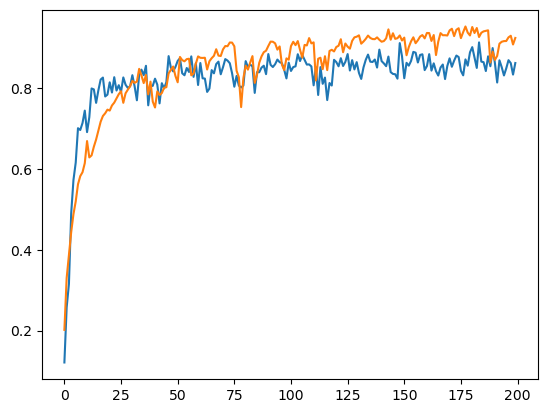

In [18]:
vf1_arr = history2.history["val_f1_score"]
f1_arr = history2.history["f1_score"]
plt.plot(range(len(vf1_arr)),vf1_arr)
plt.plot(range(len(f1_arr)),f1_arr)

In [19]:
y_res = np.argmax(model2.predict(X_test), axis=1)

17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


In [20]:
df_res = pd.DataFrame(np.argmax(model2.predict(X_test), axis=1))

17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


In [21]:
df_res = df_res.map(lambda x:y.columns.values[x])

In [22]:
df_res

,0
0,pose_no_pose
1,pose_no_pose
2,pose_situp_up
3,pose_squats_up
4,pose_jumping_jacks_down
...,...
518,pose_pullups_up
519,pose_situp_down
520,pose_no_pose
521,pose_pushups_down


In [1]:

from keras.models import Sequential
from keras.layers import Input, Conv2D, MaxPooling2D, Dense, Dropout, BatchNormalization, Resizing, Flatten
from keras.metrics import F1Score
from keras.utils import image_dataset_from_directory
from keras.callbacks import EarlyStopping
import tensorflow as tf
import os
import csv
import warnings
warnings.filterwarnings('ignore')


def stop_early(patience=10, start=10):
    # Early stopping to halt training when validation performance stops improving
    return EarlyStopping(
        monitor='val_accuracy',  # Monitor F1 score on validation data
        patience=patience,  # Number of epochs to wait for improvement
        verbose=1,
        mode='max',  # Stop when F1 score stops increasing
        restore_best_weights=True,  # Restore best weights
        start_from_epoch=start  # Epoch to start monitoring
    )


train_ds, valid_ds = image_dataset_from_directory(
    'images',
    image_size = (128,128),
    seed = 38,
    subset = 'both',
    validation_split = 0.2
)

class_names = train_ds.class_names

with open("classes.csv", "w", newline="") as file:
    writer = csv.writer(file)
    writer.writerow(class_names)

AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
valid_ds = valid_ds.cache().prefetch(buffer_size=AUTOTUNE)

model = Sequential([
    Input(shape=(128,128,3,)),
    Conv2D(16, kernel_size= 3, activation='relu', padding='same'),
    Conv2D(32, kernel_size= 3, activation='relu', padding='same'),
    Conv2D(64, kernel_size= 3, activation='relu', padding='same'),
    MaxPooling2D(pool_size=2),
    BatchNormalization(),
    Dropout(0.2),
    Conv2D(16, kernel_size= 3, activation='relu', padding='same'),
    Conv2D(32, kernel_size= 3, activation='relu', padding='same'),
    Conv2D(64, kernel_size= 3, activation='relu', padding='same'),
    MaxPooling2D(pool_size=2),
    BatchNormalization(),
    Dropout(0.2),
    Conv2D(16, kernel_size= 3, activation='relu', padding='same'),
    Conv2D(32, kernel_size= 3, activation='relu', padding='same'),
    Conv2D(64, kernel_size= 3, activation='relu', padding='same'),
    MaxPooling2D(pool_size=2),
    BatchNormalization(),
    MaxPooling2D(pool_size=2),    
    BatchNormalization(),
    Dropout(0.2),
    Conv2D(16, kernel_size= 3, activation='relu', padding='same'),
    Conv2D(32, kernel_size= 3, activation='relu', padding='same'),
    Conv2D(64, kernel_size= 3, activation='relu', padding='same'),
    MaxPooling2D(pool_size=2),
    BatchNormalization(),
    Dropout(0.2),
    Flatten(),
    Dense(64, activation='relu'),
    Dense(4, activation='softmax')
])

print(model.summary())

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.fit(
    train_ds,
    epochs=5,
    validation_data=valid_ds
)

model.save('cnn.keras')

2025-04-03 14:48:29.337366: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-04-03 14:48:29.337405: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-04-03 14:48:29.337414: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-04-03 14:48:29.544196: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Found 2951 files belonging to 4 classes.
Using 2361 files for training.
Using 590 files for validation.


2025-04-03 14:48:34.722475: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-04-03 14:48:35.652047: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-04-03 14:48:35.652288: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 16)      448       
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 32)      4640      
                                                                 
 conv2d_2 (Conv2D)           (None, 128, 128, 64)      18496     
                                                                 
 max_pooling2d (MaxPooling2  (None, 64, 64, 64)        0         
 D)                                                              
                                                                 
 batch_normalization (Batch  (None, 64, 64, 64)        256       
 Normalization)                                                  
                                                                 
 dropout (Dropout)           (None, 64, 64, 64)        0

2025-04-03 14:48:40.253798: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2025-04-03 14:48:41.745599: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8902
2025-04-03 14:48:42.179298: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2025-04-03 14:48:44.814988: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x5cb809d12500 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-04-03 14:48:44.815015: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce GTX 1650, Compute Capability 7.5
2025-04-03 14:48:44.850479: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer,

32/74 [===========>..................] - ETA: 7s - loss: 0.9902 - accuracy: 0.6221

2025-04-03 14:48:57.851397: W tensorflow/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.81GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2025-04-03 14:48:57.922004: W tensorflow/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.81GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


74/74 [==============================] - 30s 237ms/step - loss: 0.6357 - accuracy: 0.7607 - val_loss: 1.3149 - val_accuracy: 0.4559
Epoch 2/5
74/74 [==============================] - 13s 176ms/step - loss: 0.1752 - accuracy: 0.9416 - val_loss: 1.3731 - val_accuracy: 0.4356
Epoch 3/5
74/74 [==============================] - 13s 173ms/step - loss: 0.0807 - accuracy: 0.9776 - val_loss: 1.6006 - val_accuracy: 0.4254
Epoch 4/5
74/74 [==============================] - 13s 172ms/step - loss: 0.0565 - accuracy: 0.9843 - val_loss: 0.1819 - val_accuracy: 0.9390
Epoch 5/5
74/74 [==============================] - 13s 174ms/step - loss: 0.0357 - accuracy: 0.9890 - val_loss: 0.2046 - val_accuracy: 0.9220
